In [ ]:
!pip list

In [1]:
import polars as pl
import pandas as pd

import stable_baselines3
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym  

### *Loading Data*

*Based on NASDAQ Technical 100 Stock LOB*  
*Duration - 2025-05-04 to 2025-06-04*  
*Time Interval - 1 minute*

In [2]:
df = pl.read_csv("D:\\HFT-RL\\data\\USATECHIDXUSD_mt5_ticks_2.csv")

# Convert Timestamp column to datetime
df_with_datetime = df.with_columns(
    pl.col("Timestamp").str.strptime(pl.Datetime, format=
    "%Y%m%d %H:%M:%S:%3f").alias("datetime")
)

df = df_with_datetime.drop("Timestamp")
df = df.to_pandas()

In [3]:
df[['Bid price', 'Bid volume']].head(10)

,Bid price,Bid volume
0,20046.264,0.00009
1,20046.109,0.00009
2,20046.121,0.00009
3,20046.109,0.00009
4,20046.154,0.00009
5,20046.232,0.00009
6,20046.787,0.00009
7,20046.387,0.00009
8,20046.565,0.00009
9,20046.832,0.00009


In [4]:
from envs.env import TradingEnv
import pandas as pd

info {'cash_in_hand': np.float32(9975.257), 'shares_held': np.float32(0.0012269985), 'net_worth': np.float32(9999.856)}


<function matplotlib.pyplot.show(close=None, block=None)>

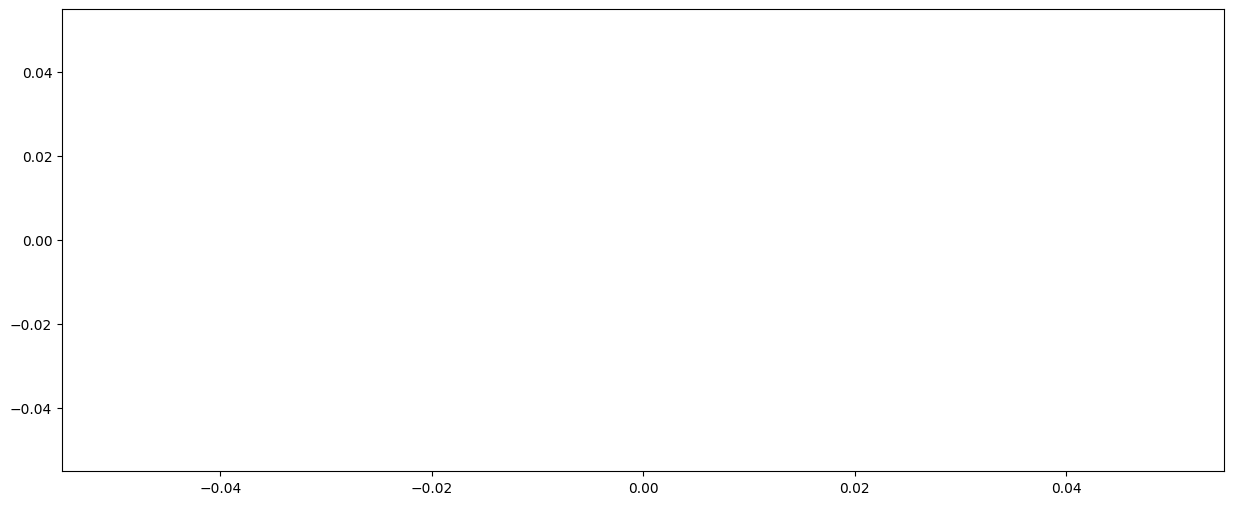

In [ ]:
env = TradingEnv(df)
state = env.reset()
while True:
    action = env.action_space.sample()  # Random action
    n_state, reward, done, _, info = env.step(action)
    if done:
        print("info", info)
        break
plt.figure(figsize = (15,6))
plt.plot(tracker, label='Portfolio Value')
# env.render_all()
plt.show

In [13]:
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO

vec_env = DummyVecEnv([lambda: TradingEnv(df, episode_length=100000)])
policy_kwargs = dict(
    net_arch=[64, 64],
    activation_fn="relu",
)
model = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1)
model.learn(total_timesteps=1000)


Using cuda device
----------------------------
| time/              |     |
|    fps             | 90  |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 128 |
----------------------------
----------------------------
| time/              |     |
|    fps             | 90  |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 34           |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0033286405 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.181        |
|    learning_rate        | 0.0003       |
|    loss        

In [14]:
# Evaluate the trained QRDQN model on the TradingEnv and plot portfolio value over an episode

env = TradingEnv(df)
state = env.reset()
portfolio_values = []

while True:
    # Use only the observation part for model prediction
    obs = state[0] if isinstance(state, tuple) else state
    action = model.predict(obs, deterministic=True)
    n_state, reward, done, _, info = env.step(action)
    # portfolio_values.append(tracker)
    state = n_state
    if done:
        print("info", info)
        break

# plt.figure(figsize=(15, 6))
# plt.plot(portfolio_values, label='Portfolio Value')
# plt.xlabel('Step')
# plt.ylabel('Portfolio Value')
# plt.title('Portfolio Value Over Episode (QRDQN Policy)')
# plt.legend()
# plt.show()

info {'cash_in_hand': 10000, 'shares_held': 0.0, 'net_worth': np.float32(10000.0)}
